# [Kaggle Competition: Bike Sharing Demand](https://www.kaggle.com/competitions/bike-sharing-demand/overview)

### Forecasting use of a city bikeshare system

In [1]:
# Import libraries

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor

from xgboost import XGBRegressor

## 1. Data description:

First, let's read in the data into a pandas dataframe:

In [2]:
df = pd.read_csv('train.csv')
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


The training dataset for this Kaggle competition consists of approximately 10000 samples with 12 features (a mixture of both continuous and categorical data), including the total number of bikes in use on a particular day. Our task is to predict this integer value.

We can first check for missing (null) values in our dataset:

In [3]:
df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


There are no missing values. Note we can use **pandas.DatetimeIndex** to convert the datetime variables into separate hour, day, dayofweek, month, and year variables:

In [4]:
df['year']= pd.DatetimeIndex(df['datetime']).year
df['month']= pd.DatetimeIndex(df['datetime']).month
df['day']= pd.DatetimeIndex(df['datetime']).day
df['dayofweek']= pd.DatetimeIndex(df['datetime']).dayofweek
df['hour']= pd.DatetimeIndex(df['datetime']).hour

Now the dataframe has five extra columns for year, month, day, hour, and day of the week, and we can drop the datetime column.

In [5]:
df = df.drop("datetime", axis=1)
df.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,dayofweek,hour
0,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,5,0
1,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,5,1
2,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,5,2
3,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,5,3
4,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,5,4


A description of the remaining features is given below:

**season**: 1: Spring, 2: Summer, 3: Fall, 4: Winter <br>
**holiday**: 1: Holiday, 0: Non-holiday <br>
**workingday**: 1: Workday, 0: Non-workday <br>
**weather**: 1: Clear, 2: Mist, 3: Light rain, 4: Heavy rain <br>
**temp**: Temperature in Celsius <br>
**atemp**: "Feels like" temperature in Celsius <br>
**humidity**: Relative humidity <br>
**windspeed**: Wind speed <br>
**casual**: Number of non-registered user rentals <br>
**registered**: Number of registered user rentals <br>
**count**: Total number of rentals <br>

The dataset contains a mix of categorical and continuous variables as shown below.

In [6]:
categorical_variables = ["season", "holiday", "workingday", "weather", "year", "month", "day", "dayofweek", "hour"]
continuous_variables = ["temp", "atemp", "humidity", "windspeed", "casual", "registered", "count"]

print(f'There are {len(categorical_variables)} categorical variables.')
print(f'There are {len(continuous_variables)} continuous variables.')

There are 9 categorical variables.
There are 7 continuous variables.


## 2. Exploratory Data Analysis:

First we can look at the distribution of **count**, i.e. the variable which gives the total number of rented bikes for a given training sample. The distribution is heavily skewed right (i.e. has a tail on the right side) thus is not well approximated by a normal distribution.

### Proability density of total bike usage and logarithmic transformation:

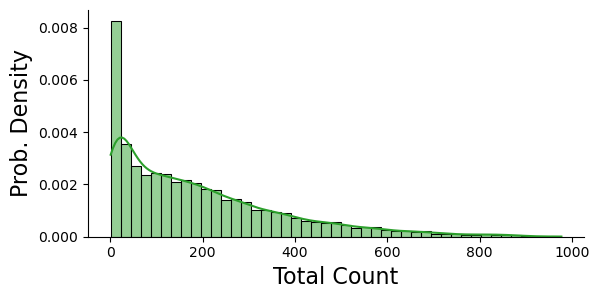

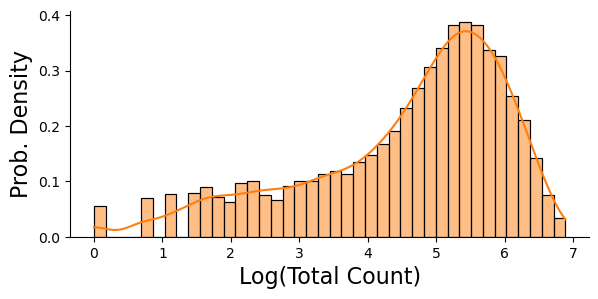

In [7]:
sns.displot(df["count"], kde=True, height=3, aspect=2, stat='density', color='tab:green')
plt.xlabel('Total Count', fontsize=16)
plt.ylabel('Prob. Density', fontsize=16)

sns.displot(np.log(df["count"]), kde=True, height=3, aspect=2, stat='density', color='tab:orange')
plt.xlabel('Log(Total Count)', fontsize=16)
plt.ylabel('Prob. Density', fontsize=16)
plt.show()

Taking the natural log of the count data gives a distribution slightly more normally distributed, as shown above, and also in the quantile-quantile (Q-Q) plots below. Here the quantiles of the data (i.e. the values in order) are plotted against the same quantilies of a theoretical normal distribution:

### Q-Q plots for total bike usage and logarithmic transformation:

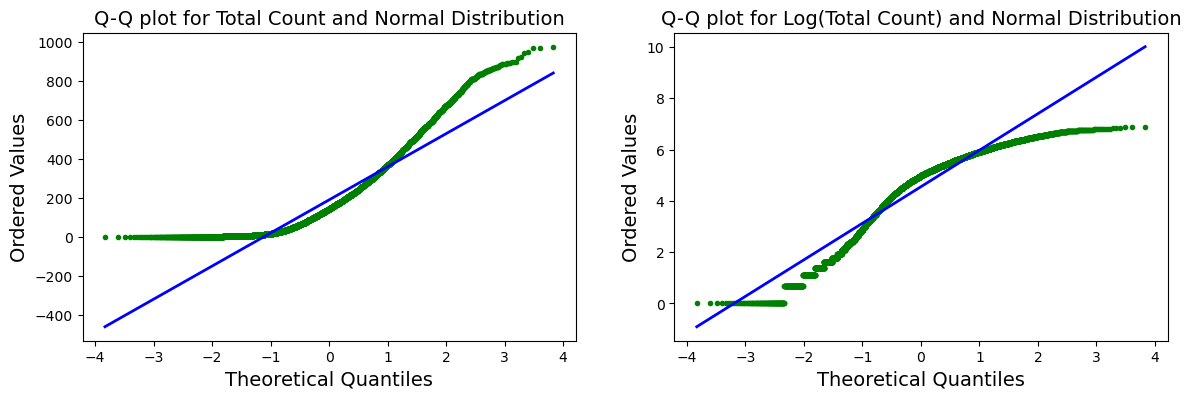

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
scipy.stats.probplot(df["count"], dist="norm", fit=True, plot=ax[0])
scipy.stats.probplot(np.log(df["count"]), dist="norm", fit=True, plot=ax[1])
ax[0].set_title('Q-Q plot for Total Count and Normal Distribution', fontsize=14)
ax[0].set_xlabel('Theoretical Quantiles', fontsize=14)
ax[0].set_ylabel('Ordered Values', fontsize=14)
ax[0].get_lines()[0].set_marker('.')
ax[0].get_lines()[0].set_markerfacecolor('g')
ax[0].get_lines()[0].set_markeredgecolor('g')
ax[0].get_lines()[1].set_linewidth(2.0)
ax[0].get_lines()[1].set_color('b')

ax[1].set_title('Q-Q plot for Log(Total Count) and Normal Distribution', fontsize=14)
ax[1].set_xlabel('Theoretical Quantiles', fontsize=14)
ax[1].set_ylabel('Ordered Values', fontsize=14)
ax[1].get_lines()[0].set_marker('.')
ax[1].get_lines()[0].set_markerfacecolor('g')
ax[1].get_lines()[0].set_markeredgecolor('g')
ax[1].get_lines()[1].set_linewidth(2.0)
ax[1].get_lines()[1].set_color('b')

plt.show()

We can also visualize the **disribution of the total count** for different categorical variables, such as **season**, **weather**, **month**, and **working day**. Using box plots, we can also see the number of outlier variables (which exceed $Q3+(1.5*IQR)$) displayed as dots.

Immediately we can see that bike usage is higher in clear weather and during the summer and fall months. To study the correlations between features further, we can produce a plot of the 2D correlation matrix.

### Distribution of bike usage with season, weather, month, and working day:

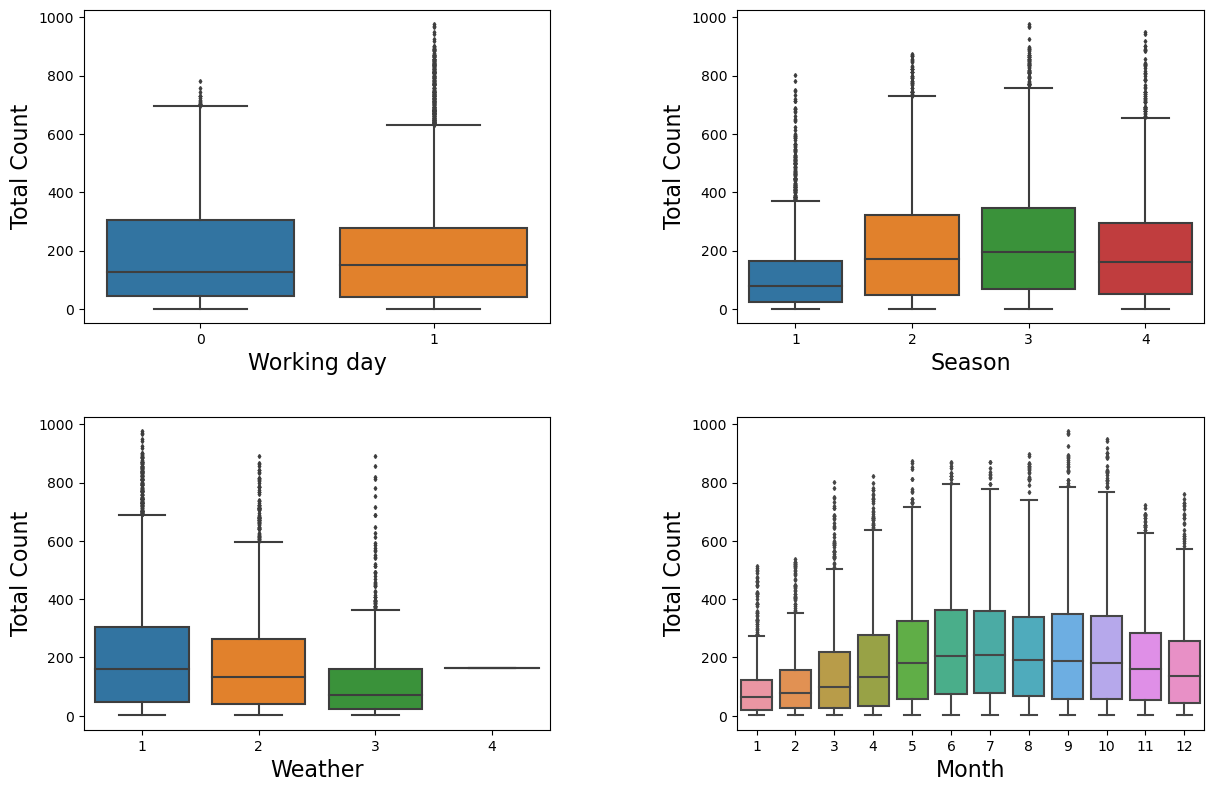

In [9]:
fig, axs = plt.subplots(2, 2)
fig.set_size_inches(14,9)
sns.boxplot(data=df, y="count", x="workingday", ax=axs[0][0], fliersize=2)
sns.boxplot(data=df, y="count", x="season", ax=axs[0][1], fliersize=2)
sns.boxplot(data=df, y="count", x="weather", ax=axs[1][0], fliersize=2)
sns.boxplot(data=df, y="count", x="month", ax=axs[1][1], fliersize=2)
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.3)
axs[0][0].set_xlabel('Working day', fontsize=16)
axs[0][0].set_ylabel('Total Count', fontsize=16)
axs[0][1].set_xlabel('Season', fontsize=16)
axs[0][1].set_ylabel('Total Count', fontsize=16)
axs[1][0].set_xlabel('Weather', fontsize=16)
axs[1][0].set_ylabel('Total Count', fontsize=16)
axs[1][1].set_xlabel('Month', fontsize=16)
axs[1][1].set_ylabel('Total Count', fontsize=16)
plt.show()

We can also plot a **correlation heatmap** showing the 2D correlation matrix for the features in our dataset. 

Several features have a positive correlation with the total count, such as the hour $(+0.4)$, temperature $(+0.39)$, and "atemp" $(+0.39)$, the feels-like temperature. However temperature and atemp have a correlation of almost $1$, so it may be better to simply remove the atemp data. There is also a clear negative correlation $(-0.32)$ between total count and humidity.

### Correlation heatmap:

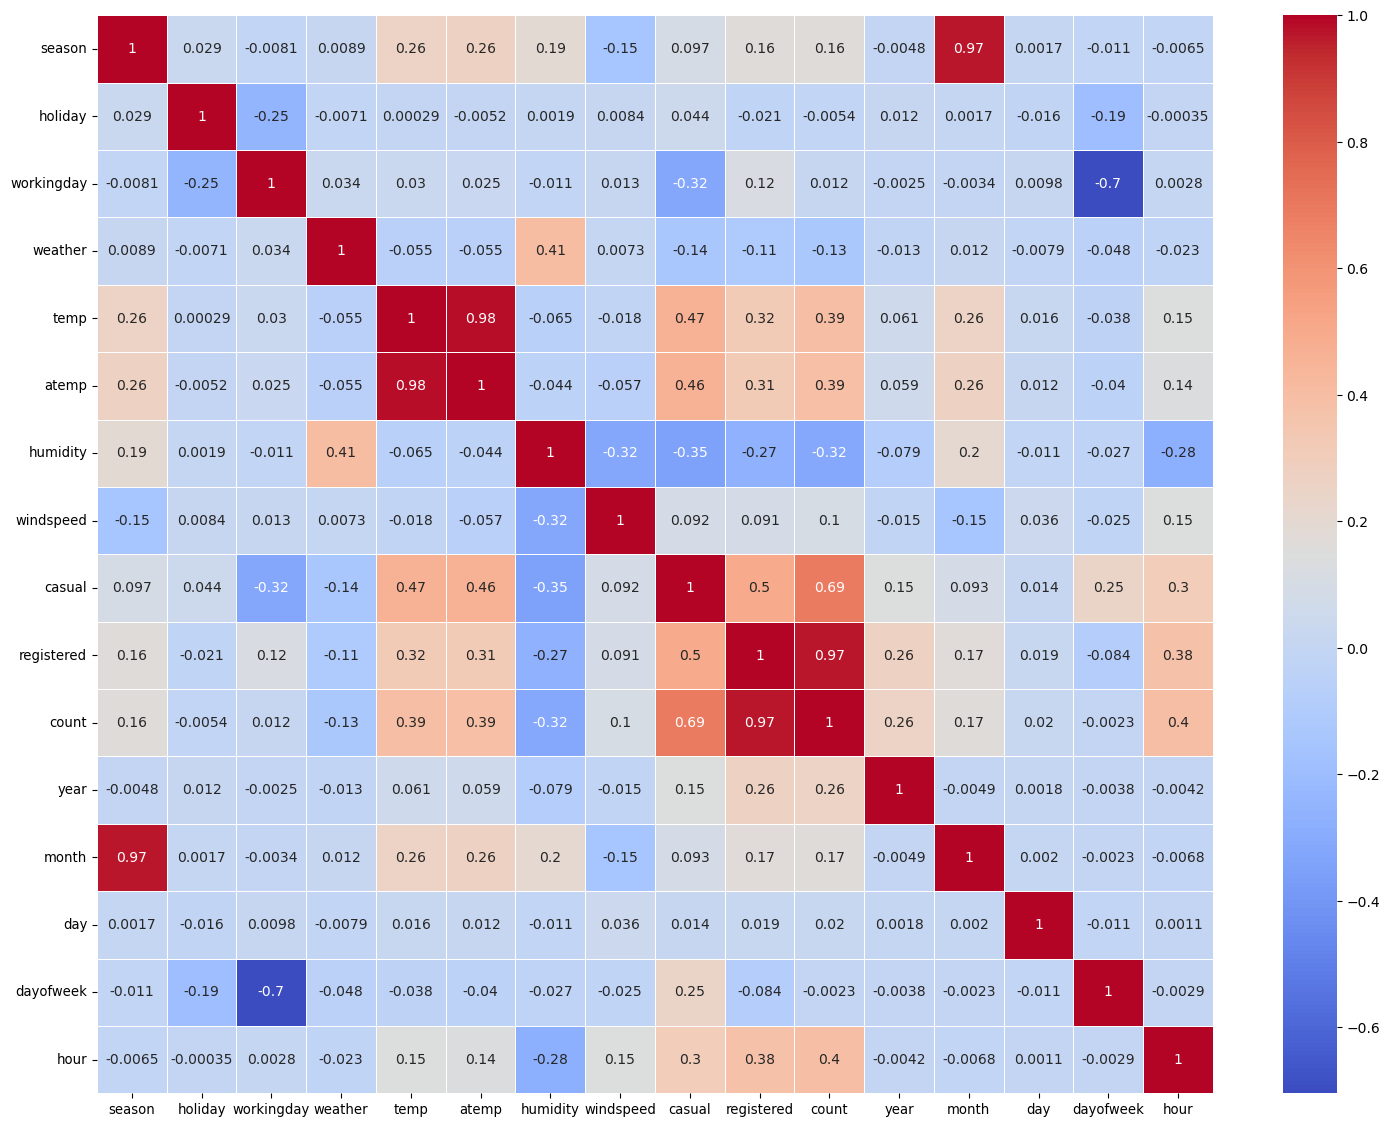

In [10]:
plt.figure(figsize=(18,14))
corr = df.corr()
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, linewidths=.5, cmap='coolwarm', annot=True)
plt.xticks(fontsize=9.5)
plt.yticks(fontsize=9.5)
plt.show()

There is also a positive correlation $(+0.26)$ between the year and bike usage. Our training set contains data over two years, 2011 and 2012. Indeed we can see that the mean daily usage increases by about $65\%$ from 2011 to 2012:

In [11]:
df.groupby(["year"]).mean()["count"]

year
2011    144.223349
2012    238.560944
Name: count, dtype: float64

Overall, there is little correlation between total count and the workingday variable. However, on work days usage is naturally higher at typical commuting times 08:00 and 17:00, and usage between these times (around 10:00 to 16:00) peaks on non-work days. There is little correlation $(-0.0023)$ between the total count and the day of the week, and indeed we see that the mean daily usage is very similar across the days of the week (apart from Sundays, when there is a slight dip in usage).

### Mean bike usage by day of the week and hour:

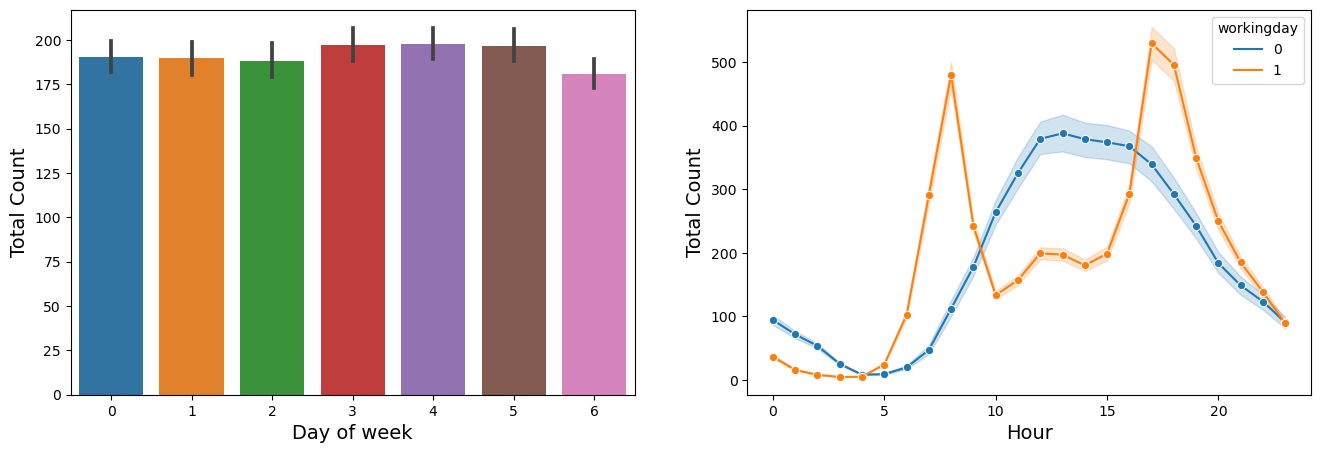

In [12]:
fig, axs = plt.subplots(1,2)
fig.set_size_inches(16,5)
sns.barplot(data=df, x="dayofweek", y="count", ax=axs[0])
sns.lineplot(data=df, x="hour", y="count", hue='workingday', marker='o', markers=True, dashes=False, ax=axs[1])
axs[0].set_xlabel("Day of week", fontsize=14)
axs[0].set_ylabel("Total Count", fontsize=14)
axs[1].set_xlabel("Hour", fontsize=14)
axs[1].set_ylabel("Total Count", fontsize=14)
plt.show()

We can visualize how daily usage varies with the continuous weather variables (temperature, atemp, wind speed, and humidity) using a **jointplot**. Here we can see visually the positive correlation between total count and the temperature (and atemp), as well as the negative correlation between total count and humidity. The distributions for workdays and non-workdays are very similar as indicated by the accompanying kde plots.  

### Total Bike Usage vs Temperature:

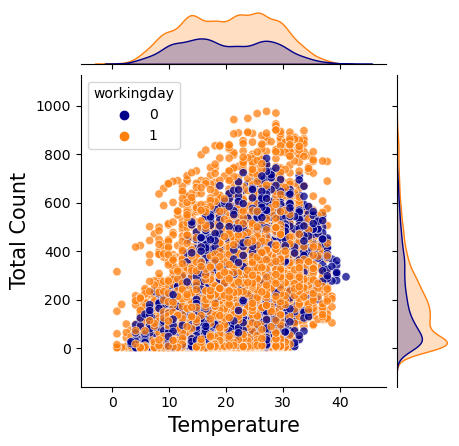

In [13]:
g1 = sns.jointplot(x="temp", y="count", data=df, hue='workingday', alpha=0.75, height=4.5, palette=["darkblue","tab:orange"])
g1.ax_joint.set_xlabel('Temperature', fontsize=15)    
g1.ax_joint.set_ylabel('Total Count', fontsize=15)    
plt.show()

### Total Bike usage vs 'Feels-like' Temperature:

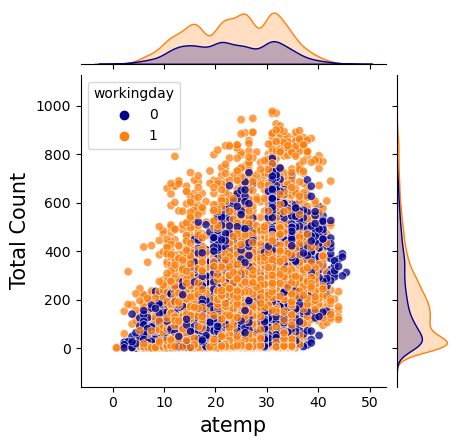

In [14]:
g2 = sns.jointplot(x="atemp", y="count", data=df, hue='workingday', alpha=0.75, height=4.5, palette=["darkblue","tab:orange"])
g2.ax_joint.set_xlabel('atemp', fontsize=15)    
g2.ax_joint.set_ylabel('Total Count', fontsize=15)    
plt.show()

### Total Bike usage vs Wind Speed:

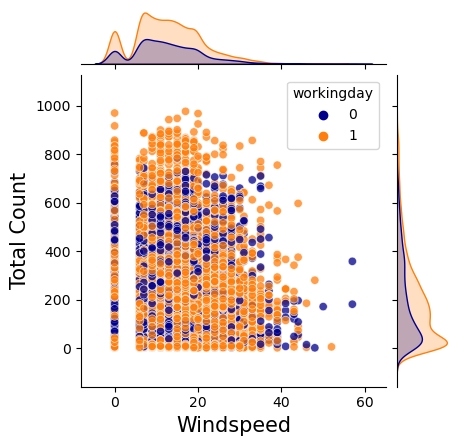

In [15]:
g3 = sns.jointplot(x="windspeed", y="count", data=df, hue='workingday', alpha=0.75, height=4.5, palette=["darkblue","tab:orange"])
g3.ax_joint.set_xlabel('Windspeed', fontsize=15)    
g3.ax_joint.set_ylabel('Total Count', fontsize=15)    
plt.show()

### Total Bike usage vs Humidity:

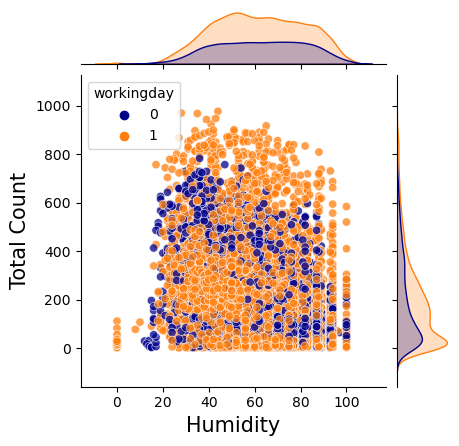

In [16]:
g4 = sns.jointplot(x="humidity", y="count", data=df, hue='workingday', alpha=0.75, height=4.5, palette=["darkblue","tab:orange"])
g4.ax_joint.set_xlabel('Humidity', fontsize=15)    
g4.ax_joint.set_ylabel('Total Count', fontsize=15)    
plt.show()

## 3. Feature Engineering:

First, note that the total **count** (the variable we will aim to predict) is the sum of the **casual** count and the **registered** count. As such, the test set does not contain data for the casual count or the registered count. We should thus drop **casual** and **registered** from our dataframe. Let us also drop **atemp** since it has almost perfect correlation with **temp**.

Secondly, note that the testing and training data (with the split made by Kaggle for the purposes of the competition) is determined by the day of the month. The combined data sets represent records ranging from January 2011 to December 2012, with data collected on or before the Day 19 of each month assigned to the training set, and data collected from Day 20 onwards assigned to the testing set by Kaggle. Consequently, we drop all day of the month data from the training set before training our models.

In [17]:
df = df.drop(["casual", "registered", "atemp", "day"], axis=1)
df.head()

,season,holiday,workingday,weather,temp,humidity,windspeed,count,year,month,dayofweek,hour
0,1,0,0,1,9.84,81,0.0,16,2011,1,5,0
1,1,0,0,1,9.02,80,0.0,40,2011,1,5,1
2,1,0,0,1,9.02,80,0.0,32,2011,1,5,2
3,1,0,0,1,9.84,75,0.0,13,2011,1,5,3
4,1,0,0,1,9.84,75,0.0,1,2011,1,5,4


The data set contains a mixture of continuous variables (temperature and windspeed) and categorical variables (such as season, weather type, month, and day of the week). However, the categorical data is expressed as an arbitrary numerical value (e.g. an integer $\{1,2,3,4\}$ for season, an integer $\{1,2,3,4\}$ for weather, etc.) Therefore we can use dummy coding, replacing the categorical data with binary dummy variables using the pandas function **pd.get_dummies**. After this, we also drop one redundant category known as the reference category. For example, only six binary variables are necessary to fully specify the day of the week.

In [18]:
df = pd.get_dummies(df, columns=['month', 'dayofweek', 'hour', 'weather', 'year', 'season'])
df = df.drop(['month_1', 'dayofweek_0', 'hour_0', 'weather_1', 'year_2011', 'season_1'], axis=1)
df.head()

,holiday,workingday,temp,humidity,windspeed,count,month_2,month_3,month_4,month_5,...,hour_21,hour_22,hour_23,weather_2,weather_3,weather_4,year_2012,season_2,season_3,season_4
0,0,0,9.84,81,0.0,16,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,9.02,80,0.0,40,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,9.02,80,0.0,32,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,9.84,75,0.0,13,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,9.84,75,0.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


As noted previously, the natural logarithm of **count** is more normally distributed. Let us replace the target variable **count** with $y=\ln(\mathrm{count}+1)$. This ensures total counts of $0$ are mapped to $0$ and not $-\infty$. The training data $X$ consists of all other data in our dataframe (now $52$ features).

In [19]:
y = np.log1p(df['count'])  
X = df.drop('count', axis=1)

Now split the labelled training set into two sets: one for training our models, and a validation set for determining the best set of hyperparameters:

In [20]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3)

Scale the data using **StandardScalar()**. Note we fit the scaler on the training data only. Then we transform both the training and validation sets using this fit.

In [21]:
scl = StandardScaler()
scl.fit(X_train) 

X_train_scaled = scl.transform(X_train)
X_valid_scaled = scl.transform(X_valid)

Finally, let's define a function **predict** that will report prediction scores for a given model:

In [22]:
def predict(model, X_test, y_test):
    y_pred = model.predict(X_test)
    print('R2 score:', r2_score(y_test, y_pred))
    print("root mean_squared_error: ", np.sqrt(mean_squared_error(y_test, y_pred)))
    print("mean_absolute_error: ", mean_absolute_error(y_test, y_pred))
    return y_pred

## 4. Training models and hyperparameter tuning with GridSearchCV:

### 4.1. Linear regression:

In [23]:
lr = LinearRegression()
lr_model = lr.fit(X_train_scaled, y_train)

print("Validation Set performance: ")
y_valid_pred_lr = predict(lr_model, X_valid_scaled, y_valid)

print('\n')

print("Training Set performance: ")
y_train_pred_lr = predict(lr_model, X_train_scaled, y_train)

Validation Set performance: 
R2 score: 0.8365614572113806
root mean_squared_error:  0.5727128837304315
mean_absolute_error:  0.429667375508494


Training Set performance: 
R2 score: 0.8319822259334771
root mean_squared_error:  0.5822892859765508
mean_absolute_error:  0.4350943914072028


### 4.2. Ridge regression:

In [27]:
ridge = GridSearchCV(Ridge(), param_grid={'alpha':10**np.linspace(4,-4,100)}, scoring="neg_mean_squared_error", cv=5)
ridge.fit(X_train_scaled, y_train)

print("GridSearchCV: Best hyperparameter alpha: ")
print(ridge.best_params_)

print('\n')

print("GridSearchCV: Best score: ")
print(ridge.best_score_)

print('\n')

print("Validation Set performance: ")
y_valid_pred_ridge = predict(ridge, X_valid_scaled, y_valid)

print('\n')

print("Training Set performance: ")
y_train_pred_ridge = predict(ridge, X_train_scaled, y_train)

GridSearchCV: Best hyperparameter alpha: 
{'alpha': 0.20565123083486514}


GridSearchCV: Best score: 
-0.3433144831565875


Validation Set performance: 
R2 score: 0.8365406040506852
root mean_squared_error:  0.5727494188483689
mean_absolute_error:  0.42973759254332977


Training Set performance: 
R2 score: 0.8319837303435244
root mean_squared_error:  0.5822866790981478
mean_absolute_error:  0.4351132685618583


### 4.3. Lasso regression:

In [28]:
lasso = LassoCV(n_alphas=100, cv=5)
lasso.fit(X_train_scaled, y_train)

print("LassoCV: Best hyperparameter alpha: ")
print(lasso.alpha_)

print('\n')

print("LassoCV: Best score: ")
print(lasso.score(X_train_scaled, y_train))

print('\n')

print("Validation set performance: ")
y_valid_pred_lasso = predict(lasso, X_valid_scaled, y_valid)

print('\n')

print("Training set performance: ")
y_train_pred_lasso = predict(lasso, X_train_scaled, y_train)


LassoCV: Best hyperparameter alpha: 
0.000567261975731949


LassoCV: Best score: 
0.8319376926802985


Validation set performance: 
R2 score: 0.8361312946882687
root mean_squared_error:  0.5734660650979831
mean_absolute_error:  0.4305937089592225


Training set performance: 
R2 score: 0.8319376926802985
root mean_squared_error:  0.5823664489978245
mean_absolute_error:  0.43531183529973383


### 4.4. K-Nearest-Neighbors (KNN) Regression:

In [32]:
knn = GridSearchCV(KNeighborsRegressor(), param_grid={"n_neighbors":list(range(1, 41))}, cv=10, scoring="neg_mean_squared_error")
knn.fit(X_train_scaled, y_train)

print("KNN best k-value: ")
print(knn.best_params_)

print('\n')

print("KNN best score: ")
print(knn.best_score_)

print('\n')

print("Validation set performance: ")
y_valid_pred_knn = predict(knn, X_valid_scaled, y_valid)

print('\n')

print("Training set performance: ")
y_train_pred_knn = predict(knn, X_train_scaled, y_train)

KNN best k-value: 
{'n_neighbors': 6}


KNN best score: 
-0.2331589229740078


Validation set performance: 
R2 score: 0.8918175373128037
root mean_squared_error:  0.46594874265652053
mean_absolute_error:  0.347117556257508


Training set performance: 
R2 score: 0.9210848119780581
root mean_squared_error:  0.399063018886649
mean_absolute_error:  0.2957468324568834


### 4.5. Decision Tree Regression:

In [33]:
dtr_params ={"splitter":["best", "random"],
            "max_depth":[2, 4, 6, 8, 10, 12, 16],
            "min_samples_leaf":[1, 2, 4, 8],
            "max_features":[2, 4, 8, 12, 16]}

dtr_model = GridSearchCV(DecisionTreeRegressor(), param_grid=dtr_params, scoring="neg_mean_squared_error", cv=5, verbose=1)

dtr_model.fit(X_train_scaled, y_train)

print("Decision Tree best params: \n")
print(dtr_model.best_params_)

print('\n')

print("Decision Tree best score: \n")
print(dtr_model.best_score_)

print('\n')

print("Validation set performance: ")
y_valid_pred_dtr = predict(dtr_model, X_valid_scaled, y_valid)

print('\n')

print("Training set performance: ")
y_train_pred_dtr = predict(dtr_model, X_train_scaled, y_train)

Fitting 5 folds for each of 280 candidates, totalling 1400 fits
Decision Tree best params: 

{'max_depth': 16, 'max_features': 16, 'min_samples_leaf': 4, 'splitter': 'random'}


Decision Tree best score: 

-0.3918418332077914


Validation set performance: 
R2 score: 0.8171675025827068
root mean_squared_error:  0.6057402160907682
mean_absolute_error:  0.43982780848233904


Train set performance: 
R2 score: 0.8479667128285345
root mean_squared_error:  0.5538989331579338
mean_absolute_error:  0.39182612257236493


### 4.6. Random Forest Regression:

In [34]:
rf_params = {"n_estimators":[10, 50, 100, 200],
             "bootstrap":[True, False],
             "max_depth":[2, 4, 6, 8, 10, 12],
             "min_samples_leaf":[1, 2, 4, 8],
             "max_features":[2, 4, 8, 12]}

rf_model = GridSearchCV(RandomForestRegressor(), param_grid=rf_params, scoring="neg_mean_squared_error", cv=5, verbose=1)

rf_model.fit(X_train_scaled, y_train)

print("Random Forest best params: \n")
print(rf_model.best_params_)

print('\n')

print("Random Forest best score: \n")
print(rf_model.best_score_)

print('\n')

print("Validation set performance: ")
y_valid_pred_rf = predict(rf_model, X_valid_scaled, y_valid)

print('\n')

print("Training set performance: ")
y_train_pred_rf = predict(rf_model, X_train_scaled, y_train)

Fitting 5 folds for each of 768 candidates, totalling 3840 fits
Random Forest best params: 

{'bootstrap': False, 'max_depth': 12, 'max_features': 12, 'min_samples_leaf': 1, 'n_estimators': 200}


Random Forest best score: 

-0.3347322163118653


Validation set performance: 
R2 score: 0.8331311394414098
root mean_squared_error:  0.5786918453957673
mean_absolute_error:  0.4328558415564863


Train set performance: 
R2 score: 0.8679026829036653
root mean_squared_error:  0.5163072035848586
mean_absolute_error:  0.3827455760136728


### 4.7. AdaBoost Regression:

In [35]:
ada_params = {'n_estimators':[100, 200, 500],
             'learning_rate':[0.01, 0.1, 1.0],
             'base_estimator__max_depth':[4, 8, 12],
             'base_estimator__max_features':[4, 8, 12],
             'base_estimator__min_samples_leaf':[2, 4, 8],
             'base_estimator__splitter':["random", "best"]}

ada_model = GridSearchCV(estimator=AdaBoostRegressor(base_estimator=DecisionTreeRegressor()), param_grid=ada_params, scoring="neg_mean_squared_error", cv=5, verbose=1)

ada_model.fit(X_train_scaled, y_train)

print("AdaBoost best params: \n")
print(ada_model.best_params_)

print('\n')

print("AdaBoost best score: \n")
print(ada_model.best_score_)

print('\n')

print("Validation set performance: ")
y_valid_pred_ada = predict(ada_model, X_valid_scaled, y_valid)

print('\n')

print("Training set performance: ")
y_train_pred_ada = predict(ada_model, X_train_scaled, y_train)

Fitting 5 folds for each of 486 candidates, totalling 2430 fits
AdaBoost best params: 

{'base_estimator__max_depth': 12, 'base_estimator__max_features': 12, 'base_estimator__min_samples_leaf': 2, 'base_estimator__splitter': 'best', 'learning_rate': 0.01, 'n_estimators': 500}


AdaBoost best score: 

-0.32150251653353557


Validation set performance: 
R2 score: 0.8390578495450222
root mean_squared_error:  0.5683221887167322
mean_absolute_error:  0.43013066489899476


Training set performance: 
R2 score: 0.8773394785412895
root mean_squared_error:  0.49752348872067464
mean_absolute_error:  0.37355729461199255


### 4.8. XGBoost Regression:

In [36]:
xgb_params = {'max_depth':[2, 4, 6],
             'n_estimators':[100, 500, 1000],
             'gamma':[0, 0.5, 1],
             'learning_rate':[0.01, 0.1, 0.2, 0.3],
             'subsample': [0.4, 0.6, 0.8]}

xgb_model = GridSearchCV(estimator=XGBRegressor(), param_grid=xgb_params, scoring="neg_mean_squared_error", cv=5, verbose=1)

xgb_model.fit(X_train_scaled, y_train)

print("XGBoost best params: \n")
print(xgb_model.best_params_)

print('\n')

print("XGBoost best score: \n")
print(xgb_model.best_score_)

print('\n')

print("Validation set performance: ")
y_valid_pred_xgb = predict(xgb_model, X_valid_scaled, y_valid)

print('\n')

print("Training set performance: ")
y_train_pred_xgb = predict(xgb_model, X_train_scaled, y_train)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
XGBoost best params: 

{'gamma': 0, 'learning_rate': 0.3, 'max_depth': 2, 'n_estimators': 1000, 'subsample': 0.8}


XGBoost best score: 

-0.11086425533843995


Validation set performance: 
R2 score: 0.9504091665957298
root mean_squared_error:  0.31547170706176003
mean_absolute_error:  0.21823130000375388


Training set performance: 
R2 score: 0.9601297420332321
root mean_squared_error:  0.28365190763330816
mean_absolute_error:  0.1970664557850128
